In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# 학습용 데이터 만들기

In [ ]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/pre'
folder_list = os.listdir(base_dir)

batch_size = 1
batch_x_data = list()
batch_t_data = list()

frame_num = 20

for folder in folder_list[0:1*batch_size]:
    for n in range(10):
        file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
        temp_data = list()
        for i in range(frame_num):
            img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
            img = img.resize(size=(112, 112))
            img = np.array(img)
            img = img.reshape(112,112,3)
            temp_data.append(img)
        temp_data = np.array(temp_data)
        batch_x_data.append(temp_data)
        batch_t_data.append(n)

In [ ]:
# 리스트인 batch_x_data를 ndarray로
batch_x_data = np.array(batch_x_data)
print(batch_x_data.shape)

In [ ]:
# 축변경
batch_x_data = np.swapaxes(batch_x_data,1,2)
batch_x_data = np.swapaxes(batch_x_data,2,3)

print(batch_x_data.shape)

In [ ]:
# one_hot_encording
batch_t_data = np.array(batch_t_data)
batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
display(batch_t_data)
batch_t_data = pd.get_dummies(batch_t_data['t'])
display(batch_t_data)

In [ ]:
# 데이터 확인
figure = plt.figure(figsize=(10,10))

fig_list=list()
for i in range(20):
    fig_list.append(figure.add_subplot(5,4,i+1))
    test = batch_x_data[0,:,:,i,:]
    fig_list[i].imshow(test.reshape(112,112,3))

# 모델

In [2]:
# GPU 메모리제한
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [3]:
# 모델 작성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv3D, MaxPool3D,Flatten, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2

weight_decay = 0.005
frame_num = 20
num_class = 10

model = Sequential()
model.add(Conv3D(64,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=(112,112,frame_num,3)))
model.add(MaxPool3D((2,2,1),strides=(2,2,1),padding='same'))

model.add(Conv3D(128,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Flatten())
model.add(Dense(units=int(4096), activation='relu'))
model.add(Dense(units=int(4096), activation='relu'))

model.add(Dense(num_class, activation='softmax'))
model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 20, 64)  5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 20, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 20, 128)   221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 28, 28, 10, 128)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 28, 28, 10, 256)   884992    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 28, 28, 10, 256)   1769728   
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 14, 14, 5, 256)    0

In [4]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/pre'
folder_list = os.listdir(base_dir)

batch_size = 2
shuffle_list = list(range(0,num_class))*batch_size

for batch in range(int(40/batch_size)):
    batch_x_data = list()
    batch_t_data = list()
    for folder in folder_list[batch*batch_size:(batch+1)*batch_size]:
        for n in range(num_class):
            file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
            temp_data = list()
            for i in range(frame_num):
                img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
                img = img.resize(size=(112, 112))
                img = np.array(img)
                temp_data.append(img)
            temp_data = np.array(temp_data)
            batch_x_data.append(temp_data)
            batch_t_data.append(n)

    # 리스트인 batch_x_data를 ndarray로
    batch_x_data = np.array(batch_x_data)
    batch_t_data = np.array(batch_t_data)
    
    # 축변경
    batch_x_data = np.swapaxes(batch_x_data,1,2)
    batch_x_data = np.swapaxes(batch_x_data,2,3)
    
    # data shuffle
    random.shuffle(shuffle_list)
    
    batch_x_data = batch_x_data[shuffle_list]
    batch_t_data = batch_t_data[shuffle_list]

    # one_hot_encording
    batch_t_data = np.array(batch_t_data)
    batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
    batch_t_data = pd.get_dummies(batch_t_data['t'])
    
    # learning
    history = model.fit(x=batch_x_data, y=batch_t_data, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 0s 484ms/step - loss: 13.8259 - accuracy: 0.2500 - val_loss: 175.0567 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 528ms/step - loss: 280.9942 - accuracy: 0.2500 - val_loss: 13.0076 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 529ms/step - loss: 13.8926 - accuracy: 0.1250 - val_loss: 13.4902 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 1s 525ms/step - loss: 13.3816 - accuracy: 0.2500 - val_loss: 13.8803 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 529ms/step - loss: 13.2826 - accuracy: 0.2500 - val_loss: 13.5355 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 529ms/step - loss: 13.2281 - accuracy: 0.2500 - val_loss: 13.7279 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 1s 528ms/step - loss: 13.1943 - accuracy: 0.2500 - val_loss: 13.4113 - val_a

1/1 [==============================] - 1s 533ms/step - loss: 11.4903 - accuracy: 0.2500 - val_loss: 11.9298 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 531ms/step - loss: 11.2165 - accuracy: 0.7500 - val_loss: 11.8738 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 536ms/step - loss: 11.0860 - accuracy: 0.7500 - val_loss: 12.3472 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 1s 535ms/step - loss: 11.4447 - accuracy: 0.2500 - val_loss: 11.8382 - val_accuracy: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 1s 560ms/step - loss: 11.5542 - accuracy: 0.2500 - val_loss: 11.6617 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 534ms/step - loss: 11.3819 - accuracy: 0.2500 - val_loss: 11.7507 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 537ms/step - loss: 11.2878 - accuracy: 0.5000 - val_loss: 11.6108 - val_accurac

1/1 [==============================] - 1s 713ms/step - loss: 9.2469 - accuracy: 0.2500 - val_loss: 10.0023 - val_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 1s 569ms/step - loss: 9.1489 - accuracy: 0.5000 - val_loss: 11.6199 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 1s 687ms/step - loss: 9.0696 - accuracy: 0.2500 - val_loss: 9.9935 - val_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 1s 685ms/step - loss: 9.0331 - accuracy: 0.7500 - val_loss: 11.9303 - val_accuracy: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 1s 623ms/step - loss: 8.8536 - accuracy: 0.2500 - val_loss: 11.5498 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 580ms/step - loss: 8.7825 - accuracy: 0.2500 - val_loss: 15.5808 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 575ms/step - loss: 9.1936 - accuracy: 0.2500 - val_loss: 9.3904 - val_accuracy: 0.0

1/1 [==============================] - 1s 574ms/step - loss: 7.2703 - accuracy: 0.2500 - val_loss: 7.2933 - val_accuracy: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 1s 575ms/step - loss: 7.1709 - accuracy: 0.5000 - val_loss: 7.6157 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 1s 574ms/step - loss: 7.0907 - accuracy: 0.2500 - val_loss: 7.2927 - val_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 1s 569ms/step - loss: 7.2475 - accuracy: 0.2500 - val_loss: 7.5215 - val_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 1s 619ms/step - loss: 7.0609 - accuracy: 0.2500 - val_loss: 7.4162 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 1s 579ms/step - loss: 6.7431 - accuracy: 0.7500 - val_loss: 7.7486 - val_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 1s 577ms/step - loss: 6.4830 - accuracy: 0.7500 - val_loss: 7.6045 - val_accuracy: 0.0000e+

Epoch 7/20
1/1 [==============================] - 1s 653ms/step - loss: 5.8859 - accuracy: 0.7500 - val_loss: 6.1608 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 1s 651ms/step - loss: 5.6422 - accuracy: 0.5000 - val_loss: 5.9981 - val_accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 1s 573ms/step - loss: 5.3702 - accuracy: 0.5000 - val_loss: 6.2403 - val_accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 1s 609ms/step - loss: 5.2103 - accuracy: 0.5000 - val_loss: 5.3127 - val_accuracy: 0.5000
Epoch 11/20
1/1 [==============================] - 1s 568ms/step - loss: 6.1996 - accuracy: 0.1250 - val_loss: 5.9743 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 1s 573ms/step - loss: 5.8344 - accuracy: 0.5000 - val_loss: 5.8727 - val_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 1s 577ms/step - loss: 5.6010 - accuracy: 0.5000 - val_loss: 5.7742 - val_accuracy: 0.0

1/1 [==============================] - 1s 670ms/step - loss: 4.3993 - accuracy: 0.5000 - val_loss: 5.2981 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 605ms/step - loss: 4.3140 - accuracy: 0.5000 - val_loss: 5.0957 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 574ms/step - loss: 4.2515 - accuracy: 0.7500 - val_loss: 5.1175 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 1s 608ms/step - loss: 4.1690 - accuracy: 0.5000 - val_loss: 4.7057 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 1s 676ms/step - loss: 4.1322 - accuracy: 0.7500 - val_loss: 6.2776 - val_accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 1s 574ms/step - loss: 4.6091 - accuracy: 0.5000 - val_loss: 4.7472 - val_accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 1s 575ms/step - loss: 4.3813 - accuracy: 0.5000 - val_loss: 4.6305 - val_accuracy: 0.5000
Epoch 

1/1 [==============================] - 1s 587ms/step - loss: 5.0925 - accuracy: 0.0000e+00 - val_loss: 9.3172 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 571ms/step - loss: 6.8201 - accuracy: 0.2500 - val_loss: 4.2420 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 608ms/step - loss: 4.1833 - accuracy: 0.5000 - val_loss: 4.2800 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 1s 569ms/step - loss: 4.1561 - accuracy: 0.2500 - val_loss: 4.3193 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 586ms/step - loss: 4.1289 - accuracy: 0.2500 - val_loss: 4.3671 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 576ms/step - loss: 4.0956 - accuracy: 0.2500 - val_loss: 4.4726 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 1s 569ms/step - loss: 4.0496 - accuracy: 0.2500 - val_loss: 4.6895 - val_accuracy: 0.0000e+00

1/1 [==============================] - 1s 569ms/step - loss: 2.3026 - accuracy: 1.0000 - val_loss: 2.3572 - val_accuracy: 1.0000
Epoch 19/20
1/1 [==============================] - 1s 569ms/step - loss: 2.2525 - accuracy: 1.0000 - val_loss: 2.2684 - val_accuracy: 1.0000
Epoch 20/20
1/1 [==============================] - 1s 575ms/step - loss: 2.2275 - accuracy: 1.0000 - val_loss: 2.2518 - val_accuracy: 1.0000


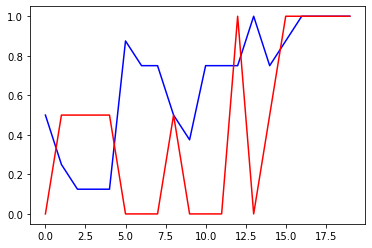

In [9]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.show()

In [6]:
batch_x_data = list()
batch_t_data = list()
for folder in folder_list[40:42]:
    for n in range(num_class):
        file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
        temp_data = list()
        for i in range(frame_num):
            img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
            img = img.resize(size=(112, 112))
            img = np.array(img)
            temp_data.append(img)
        temp_data = np.array(temp_data)
        batch_x_data.append(temp_data)
        batch_t_data.append(n)

# 리스트인 batch_x_data를 ndarray로
batch_x_data = np.array(batch_x_data)
batch_t_data = np.array(batch_t_data)

# 축변경
batch_x_data = np.swapaxes(batch_x_data,1,2)
batch_x_data = np.swapaxes(batch_x_data,2,3)

# data shuffle
random.shuffle(shuffle_list)

batch_x_data = batch_x_data[shuffle_list]
batch_t_data = batch_t_data[shuffle_list]

# one_hot_encording
batch_t_data = np.array(batch_t_data)
batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
batch_t_data = pd.get_dummies(batch_t_data['t'])

In [7]:
result = model.evaluate(x=batch_x_data, y=batch_t_data)
print(result)

1/1 [==============================] - 0s 978us/step - loss: 4.2427 - accuracy: 0.4000
[4.242713928222656, 0.4000000059604645]
